# Data Quality Homework
DU Big Data @Paris-Seine

Benoit Pimpaud

---

## Import

In [1]:
import numpy
import pandas
import random
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline
X_data = datasets.load_iris().data
y_data = datasets.load_iris().target

## Create simulation dataset

Here we create a simulation dataset to test our functions. Note the last instance which is an error made on purpose.

In [2]:
x_simu = numpy.array([[2,1,0],
                      [1,2,0],
                      [2,0,1],
                      [50,40,60],
                      [40,60,50],
                      [60,50,40],
                      [100,100,100],
                      [90,100,110],
                      [110,100,90],
                      [1,1.7,0]])

y_simu = numpy.array([0,0,0,1,1,1,2,2,2,2])

---

## Algorithms definition

In [3]:
def distance(a,b):   
    return numpy.sqrt(numpy.sum((a-b)**2))

---

### Condensed Nearest Neighbor (CNN)

In [4]:
class CondensedNearestNeighbor():
    """
    Condensed Nearest Neighbor
    """
    def __init__(self, x, y):
        """
        initialisation
        """
        self.x = x
        self.y = y
        self.n = len(y) - 1
    
    def __random_beginning(self):
        """
        create a random subset of instance for each class
        """
        self.subset_index = []
        for output_class in numpy.unique(y_data):
            alea = random.randint(0,self.n)
            while output_class != self.y[alea]:
                alea = random.randint(0,self.n)
            self.subset_index.append(alea)
    
    def __predict(self,xi):
        """
        return True if nearest neighbor in subset is the same class otherwise False
        """
        tmp_subset = self.subset_index + [xi]
        neighbor_transformer = NearestNeighbors(2).fit(self.x[tmp_subset])
        dist, indices = neighbor_transformer.kneighbors(self.x[tmp_subset])
        index = indices[len(self.subset_index)][1]
        return (self.y[xi] == self.y[self.subset_index[index]])
    
    def __searching_subset(self):
        """
        Add item to subset while there is misclassified instance
        """
        condition = True;
        while condition:
            condition = False
            i = 0
            while i <= self.n:
                if i not in self.subset_index:
                    if not self.__predict(i):
                        self.subset_index.append(i)
                        i = self.n+1
                        condition = True
                    else:
                        i += 1
                else:
                    i += 1

    def transform(self):
        self.__random_beginning()
        self.__searching_subset()
        return self.x[self.subset_index],self.y[self.subset_index]
                                                                          

Test on simulation data

In [5]:
cnn = CondensedNearestNeighbor(x_simu, y_simu)
cnn.transform()

(array([[   2. ,    1. ,    0. ],
        [  40. ,   60. ,   50. ],
        [ 100. ,  100. ,  100. ],
        [   1. ,    1.7,    0. ],
        [   1. ,    2. ,    0. ]]), array([0, 1, 2, 2, 0]))

It keeps very similar instances but with two differents classes, keeping sharped boundaries bound.

---

### Edited Nearest Neighbor

Starts with subset=training and then each instance in subset is removed if it does not agree with the majority of its knearest neighbors.

In [6]:
class EditedNearestNeighbor():
    
        def __init__(self, X, y, k=3):
            self.X = X
            self.y = y
            self.k = k
            # create subset = training set
            self.subset_x = X
            self.subset_y = y
            self.subset_index = []
            
        def predict_from_knn(self, instance):
            """
            predict instance class with is k nearest neighbors
            """
            neigh_transformer = NearestNeighbors(self.k).fit(self.subset_x)
            instance_neighbors_index = neigh_transformer.kneighbors(instance,self.k)[1]
            predictions = list(self.y[instance_neighbors_index][0])
            return max(set(predictions), key=predictions.count)
        
        def transform(self):
            """
            each instance is removed if it doesn't agree wiht the majority of its k nearest neighbors
            """
            for instance_index in range(len(self.subset_x)):
                prediction = self.predict_from_knn([self.subset_x[instance_index]])
                if (prediction != self.subset_y[instance_index]):
                    self.subset_xi = numpy.delete(self.subset_x, instance_index, 0)
                    self.subset_yi = numpy.delete(self.subset_y, instance_index, 0)
                    
            return self.subset_xi, self.subset_yi

Test on simulation data

In [7]:
enn = EditedNearestNeighbor(x_simu, y_simu, 3)
enn.transform()

(array([[   2.,    1.,    0.],
        [   1.,    2.,    0.],
        [   2.,    0.,    1.],
        [  50.,   40.,   60.],
        [  40.,   60.,   50.],
        [  60.,   50.,   40.],
        [ 100.,  100.,  100.],
        [  90.,  100.,  110.],
        [ 110.,  100.,   90.]]), array([0, 0, 0, 1, 1, 1, 2, 2, 2]))

As we can see, it removes correctly the last instance because it doesn't agree with the majority of it's k nearest neighbors

---

### Decremental Reduction Optimization Procedure Family (DROP)

In [8]:
class DecrementalReductionOptimizationProcedure():

    def __init__(self, x, y, k=3):
        self.k = k
        self.x = x
        self.y = y
        self.n = len(y)
        self.subset_index = [i for i in range(self.n)]
        
       
    def __neighbors(self):
        self.neighbors = []
        neighbor_transformer = NearestNeighbors(self.k+1).fit(self.x[self.subset_index])
        dist, indices = neighbor_transformer.kneighbors(self.x[self.subset_index])
        for i in indices:
            self.neighbors.append(i[1:self.k+1])
    
    def __initialization_associate(self):
        self.associates = [[] for i in range(len(self.subset_index))]
        for i in range(len(self.subset_index)):
            for j in self.neighbors[i][1:self.k+1]:
                self.associates[j].append(i)
                
    def __predict(self,index_test):
        c = 0
        for i in self.associates[index_test]:
            if (self.y[index_test] == self.y[i]):
                c += 1
        if self.k%2 == 0:
            res = (c >= int(self.k/2))
        else:
            res = (c > int(self.k/2))
        return res
    
    def __searching_subset(self):
        self.__neighbors()
        self.__initialization_associate()
        i=0
        while i < len(self.subset_index):
            if not self.__predict(i):
                self.__neighbors()
                self.__initialization_associate()
                self.subset_index.remove(self.subset_index[i])
            else:
                i += 1
                                 
    def transform(self):
        self.__searching_subset()
        return self.x[self.subset_index],self.y[self.subset_index]

---

## Machine learning test

### Train and test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

### Benchmark on selection and model

Deal with each combinations of selection algorithm and modelisation

In [20]:
prototype_selection = [None, CondensedNearestNeighbor, EditedNearestNeighbor, DecrementalReductionOptimizationProcedure]
models = [LogisticRegression(), DecisionTreeClassifier()]

result = []
for model in models:
    for selection in prototype_selection:
        # prototype selection
        if(selection==None):
            x_train_proto, y_train_proto = x_train, y_train
            selection_name = "None"
        else:
            x_train_proto, y_train_proto = selection(x_train, y_train).transform()
            selection_name = selection.__name__
            
        # fit model
        model.fit(x_train_proto, y_train_proto)
        y_pred = model.predict(x_test)
        
        # performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')
        r2 = r2_score(y_test, y_pred)
        n_instance = len(x_train_proto)
        
        result.append([selection_name, model, accuracy, precision, recall, r2, n_instance])
        
benchmark_result = pandas.DataFrame(result, columns=["selection_name", "model", "accuracy", "precision", "recall", "R2", "n_instance"])

In [21]:
benchmark_result

selection_name  \
0                                       None   
1                   CondensedNearestNeighbor   
2                      EditedNearestNeighbor   
3  DecrementalReductionOptimizationProcedure   
4                                       None   
5                   CondensedNearestNeighbor   
6                      EditedNearestNeighbor   
7  DecrementalReductionOptimizationProcedure   

                                               model  accuracy  precision  \
0  LogisticRegression(C=1.0, class_weight=None, d...  0.977778   0.977778   
1  LogisticRegression(C=1.0, class_weight=None, d...  0.800000   0.800000   
2  LogisticRegression(C=1.0, class_weight=None, d...  0.977778   0.977778   
3  LogisticRegression(C=1.0, class_weight=None, d...  0.711111   0.711111   
4  DecisionTreeClassifier(class_weight=None, crit...  1.000000   1.000000   
5  DecisionTreeClassifier(class_weight=None, crit...  0.666667   0.666667   
6  DecisionTreeClassifier(class_weight=None, crit...  1.000000   1.000000   
7  DecisionTreeClassifier(class_weight=None, crit...  1.000000   1.000000   

     recall        R2  n_instance  
0  0.977778  0.967949         105  
1  0.800000  0.711538          18  
2  0.977778  0.967949         104  
3  0.711111  0.583333          13  
4  1.000000  1.000000         105  
5  0.666667  0.423077          16  
6  1.000000  1.000000         104  
7  1.000000  1.000000          13

We can notice how the CNN lowers the performances for both algorithms, due to the small number of instances remaining in the training set.
ENN doesn't remove a lot of instance but it work as well as when we don't proceed prototype selection.
The best compromise between performances and size of training set is when we use DROP. It remain only 13 instances in the training set but performances don't decreased that much (only in Logistic Regression) and so training time is reduced.

For AUC we need to binarize the ouput, so process is a bit different:

In [22]:
def compute_roc(prototype_selection, model, X_data, y_data):
    
    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.5,
                                                        random_state=0)
    if(prototype_selection!=None):
        X_train, y_train = prototype_selection(X_train, y_train).transform()
        prototype_selection_name= prototype_selection.__name__
    else:
        prototype_selection_name = "None"
        
    
    # Binarize the output
    y_train = label_binarize(y_train, classes=[0, 1, 2])
    y_test = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_train.shape[1]
    

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = numpy.unique(numpy.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = numpy.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(prototype_selection_name + " - " + str(model))
    plt.legend(loc="lower right")
    plt.show()

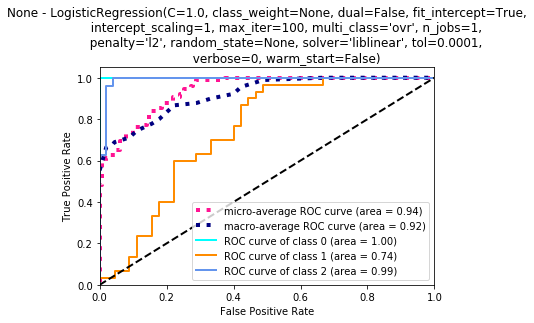

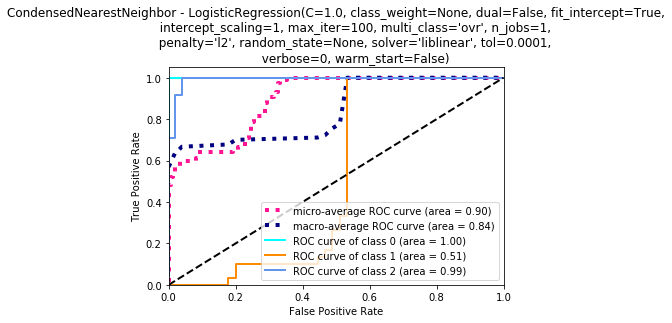

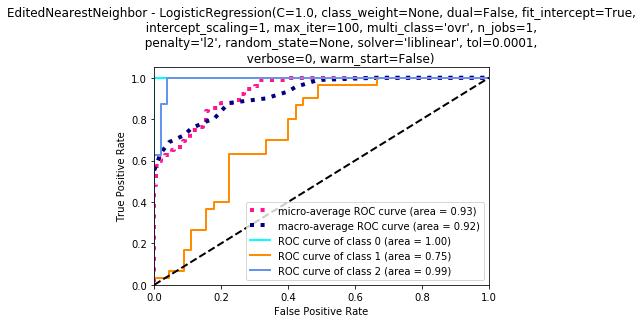

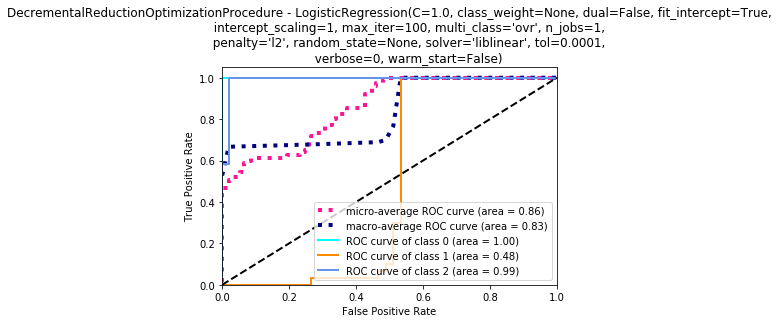

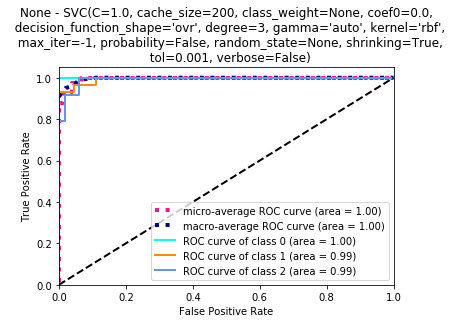

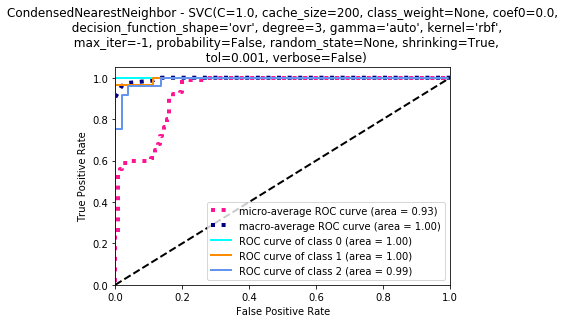

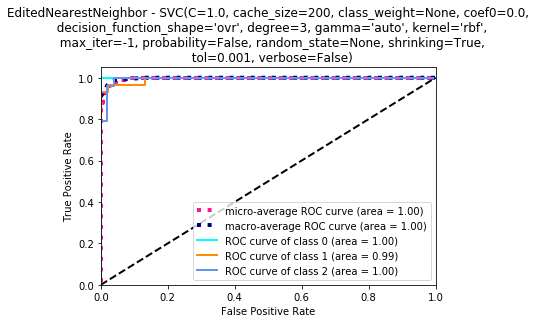

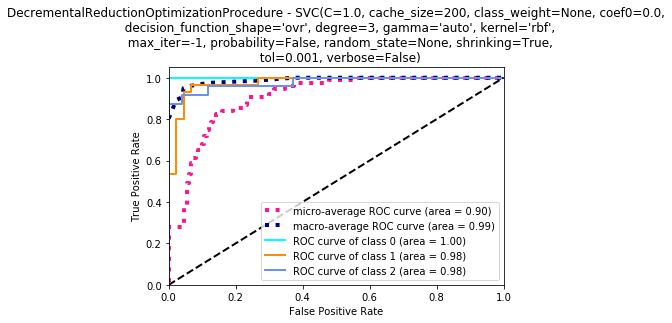

In [13]:
prototype_selection = [None, CondensedNearestNeighbor, EditedNearestNeighbor, DecrementalReductionOptimizationProcedure]
models = [LogisticRegression(), SVC()]
for model in models:
    for selection in prototype_selection:
        compute_roc(selection, model, X_data, y_data)

These curves don't bring a lot of more details beyond the fact that algorithms have difficulties to predict class 1. However, prototype selections don't affect so much performance here (something logic because these methods try to keep as much information as possible).